## Analysis for post ratio from each opinion side

show timeseries plot of post

In [ ]:
import os
import glob
import json
import yaml
import hashlib
import pandas as pd
import numpy as np
import networkx as nx
import re
import xml.etree.ElementTree as ET
from scipy import stats

# ==========================================
# 設定
# ==========================================
RESULTS_DIR = "./results"
SUMMARY_ROOT = "./results/summary"
DEST_DIR = ""
STEP_EARLY_BOUNDARY = 20000
TARGET_STEPS = [0, 20000, 50000]
BINS = ["bin_0", "bin_1", "bin_2", "bin_3", "bin_4"]

class ExperimentArchiver:
    def __init__(self, results_dir, summary_root):
        self.results_dir = results_dir
        self.summary_root = summary_root

    # ---------------------------------------------------------
    # ★追加: ターゲット方向を判定するロジック
    # ---------------------------------------------------------
    def get_target_direction(self, seed, config):
        """
        Seed番号やConfigから、その回の操作目標が プラス(+1) か マイナス(-1) かを判定する。
        
        【ルール例】
        - Configに `target_opinion` があればそれを使う
        - なければ、Seed番号で振り分ける（ユーザー定義ルール）
          例: Seed 15~19はプラス、20~24はマイナス
        """
        # 1. Configに明記されている場合
        if "target_opinion" in config:
            return np.sign(float(config["target_opinion"]))
        
        # 2. Configにない場合、Seedによるルール適用 (仮の実装)
        # ※必要に応じてここを書き換えてください
        # 例: start_seed=15, num_seed=10 の場合、前半5つ(15-19)は+1, 後半(20-24)は-1
        try:
            s = int(seed)
            start = int(config.get("start_seed", 0))
            num = int(config.get("num_seed", 10))
            mid_point = start + (num // 2)
            
            if s < mid_point:
                return 1.0  # 前半はプラス方向
            else:
                return -1.0 # 後半はマイナス方向
        except:
            return 1.0 # デフォルト

    # ---------------------------------------------------------
    # ★追加: 指標の相対化 (Normalize)
    # ---------------------------------------------------------
    def normalize_metrics(self, raw_metrics, target_sign):
        """
        ターゲット方向(target_sign)に基づいて、
        Bin_0...4 を `Opposite`(逆側) ... `Target`(目標側) に変換する
        
        Mapping:
        If Target (+): 
           Opposite(Backfire) = Bin_0
           Target(Success)    = Bin_4
        If Target (-):
           Opposite(Backfire) = Bin_4
           Target(Success)    = Bin_0
        """
        normalized = raw_metrics.copy()
        
        # 相対的なキー名
        keys = ["extreme_opp", "mod_opp", "neutral", "mod_tar", "extreme_tar"]
        
        # 変換対象のプレフィックス (例: "post_step20000_", "post_avg_late_")
        prefixes = set()
        for k in raw_metrics.keys():
            for b in BINS:
                if k.endswith(b):
                    prefixes.add(k[:-len(b)]) # "bin_0" の前までを取得
        
        for pre in prefixes:
            # 元の値を取得
            vals = [raw_metrics.get(f"{pre}bin_{i}", 0) for i in range(5)]
            
            if target_sign < 0:
                # ターゲットがマイナスの場合、Binの並びを逆転させる
                # Bin 0(Target) -> vals[0] が extreme_tar になるように
                # つまり [Bin0, Bin1, Bin2, Bin3, Bin4] 
                # Target(-)なら: Bin0=ExtremeTar, Bin4=ExtremeOpp
                # 並び: [ExtremeTar, ModTar, Neut, ModOpp, ExtremeOpp]
                # これを keys の順序 [ExOpp, ModOpp, Neut, ModTar, ExTar] に合わせるには…
                # 単純に vals を逆順にすれば良いわけではない。
                # keys: [ExOpp(B4), ModOpp(B3), Neut(B2), ModTar(B1), ExTar(B0)]
                mapped_vals = list(reversed(vals))
            else:
                # ターゲットがプラスの場合
                # keys: [ExOpp(B0), ModOpp(B1), Neut(B2), ModTar(B3), ExTar(B4)]
                mapped_vals = vals
            
            # 新しいキーで保存
            for k_name, val in zip(keys, mapped_vals):
                normalized[f"{pre}rel_{k_name}"] = val
                
        # まとめて集計用の指標も作成
        # Backfire Sum (Extreme Opp + Mod Opp)
        for pre in prefixes:
            normalized[f"{pre}sum_backfire"] = normalized.get(f"{pre}rel_extreme_opp",0) + normalized.get(f"{pre}rel_mod_opp",0)
            normalized[f"{pre}sum_success"]  = normalized.get(f"{pre}rel_extreme_tar",0) + normalized.get(f"{pre}rel_mod_tar",0)

        return normalized

    # --- 以下、既存メソッド ---
    def load_config(self):
        candidates = [
            os.path.join(self.results_dir, "config.yaml"),
            os.path.join(self.results_dir, "config.yml")
        ]
        runs = glob.glob(os.path.join(self.results_dir, "run_*"))
        if runs:
            candidates.append(os.path.join(runs[0], "config.yaml"))
        for path in candidates:
            if os.path.exists(path):
                print(f"Loading config from: {path}")
                with open(path, 'r') as f: return yaml.safe_load(f)
        return {}

    def get_topology_info(self, config):
        topology = config.get("topology", "Unknown")
        net_params = config.get("network_params", {})
        if not net_params: return topology, "default"
        param_parts = [f"{k}_{net_params[k]}" for k in sorted(net_params.keys())]
        return topology, "_".join(param_parts)

    def generate_experiment_id(self, config):
        exclude_keys = ["topology", "network_params", "start_seed", "end_seed", "num_seed", "target_opinion"] # target_opinionも実験条件としてはまとめる(混ぜるため)
        analysis_params = {k: v for k, v in config.items() if k not in exclude_keys}
        param_str = json.dumps(analysis_params, sort_keys=True, default=str)
        exp_id = hashlib.md5(param_str.encode()).hexdigest()[:8]
        return exp_id, analysis_params

    def robust_read_gexf(self, fpath):
        try:
            tree = ET.parse(fpath)
            root = tree.getroot()
            for elem in root.iter():
                if '}' in elem.tag: elem.tag = elem.tag.split('}', 1)[1]
            G = nx.DiGraph()
            for node in root.findall(".//node"): G.add_node(node.get("id"))
            for edge in root.findall(".//edge"): G.add_edge(edge.get("source"), edge.get("target"))
            return G
        except: return None

    def load_network_metrics(self, run_dir, step):
        gexf_pattern = os.path.join(run_dir, "GEXF", "*", f"step_{step}.gexf")
        files = glob.glob(gexf_pattern)
        metrics = {f"nw_step{step}_density": np.nan, f"nw_step{step}_clustering": np.nan, f"nw_step{step}_gamma": np.nan}
        if not files: return metrics
        try:
            G = self.robust_read_gexf(files[0])
            if G is None or len(G.nodes) == 0: return metrics
            metrics[f"nw_step{step}_density"] = nx.density(G)
            G_und = G.to_undirected()
            metrics[f"nw_step{step}_clustering"] = nx.average_clustering(G_und)
            degrees = [d for n, d in G.degree()]
            if len(degrees) > 10:
                k = np.array(degrees); k = k[k > 0]
                if len(k) > 10:
                    hist, bins_edge = np.histogram(k, bins=15, density=True)
                    centers = (bins_edge[:-1] + bins_edge[1:]) / 2
                    valid = hist > 0
                    if np.sum(valid) > 2:
                        slope, _, _, _, _ = stats.linregress(np.log(centers[valid]), np.log(hist[valid]))
                        metrics[f"nw_step{step}_gamma"] = -slope
        except: pass
        return metrics

    def load_post_data(self, run_dir):
        post_dir = os.path.join(run_dir, "posts")
        if not os.path.exists(post_dir): return pd.DataFrame()
        files = glob.glob(os.path.join(post_dir, "post_result_*.csv"))
        records = []
        for f in files:
            match = re.search(r"post_result_(\d+)\.csv", os.path.basename(f))
            if not match: continue
            step = int(match.group(1))
            try:
                df_temp = pd.read_csv(f)
                if df_temp.empty: continue
                row = df_temp.iloc[0]
                record = {"step": step}
                for b in BINS: record[b] = row.get(b, 0)
                if "sumOfPosts" in row: record["sumOfPosts"] = row["sumOfPosts"]
                else: record["sumOfPosts"] = sum(record[b] for b in BINS)
                records.append(record)
            except: pass
        if not records: return pd.DataFrame()
        return pd.DataFrame(records).sort_values("step")

    def extract_metrics_from_run(self, run_dir, seed_str, config):
        metrics = {}
        # Target Directionの判定
        target_sign = self.get_target_direction(seed_str, config)
        metrics["target_direction"] = target_sign

        df_post = self.load_post_data(run_dir)
        if not df_post.empty:
            for step in TARGET_STEPS:
                if step in df_post['step'].values:
                    row = df_post[df_post['step'] == step].iloc[0]
                    metrics[f"post_step{step}_sum"] = row["sumOfPosts"]
                    for b in BINS: metrics[f"post_step{step}_{b}"] = row[b]
                else:
                    metrics[f"post_step{step}_sum"] = np.nan
            df_early = df_post[df_post['step'] <= STEP_EARLY_BOUNDARY]
            df_late = df_post[df_post['step'] > STEP_EARLY_BOUNDARY]
            for b in BINS:
                metrics[f"post_avg_early_{b}"] = df_early[b].mean() if not df_early.empty else 0
                metrics[f"post_avg_late_{b}"] = df_late[b].mean() if not df_late.empty else 0
        
        for step in TARGET_STEPS:
            metrics.update(self.load_network_metrics(run_dir, step))
            
        # ★ここで相対化を実行
        metrics = self.normalize_metrics(metrics, target_sign)
        return metrics

    def run(self):
        config = self.load_config()
        topology, net_param_str = self.get_topology_info(config)
        exp_id, analysis_params = self.generate_experiment_id(config)
        dest_dir = os.path.join(self.summary_root, topology, net_param_str, exp_id)
        os.makedirs(dest_dir, exist_ok=True)
        DEST_DIR = dest_dir  # グローバル変数にもセット
        print(f"Target Directory: {dest_dir}")

        run_dirs = sorted(glob.glob(os.path.join(self.results_dir, "run_*")))
        all_metrics = []
        for r_dir in run_dirs:
            # run_15 などの数値部分をSeedとして扱う
            run_name = os.path.basename(r_dir)
            try:
                seed_str = run_name.split("_")[1]
            except:
                seed_str = "0"

            print(f"Processing {run_name} (Seed: {seed_str})...")
            m = self.extract_metrics_from_run(r_dir, seed_str, config)
            if m:
                m["run_id"] = run_name
                m["seed"] = seed_str
                all_metrics.append(m)
        
        if not all_metrics:
            print("No valid data found.")
            return

        df_all = pd.DataFrame(all_metrics)
        summary_stats = {}
        numeric_cols = df_all.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            summary_stats[f"{col}_mean"] = df_all[col].mean()
            summary_stats[f"{col}_std"] = df_all[col].std()
            summary_stats[f"{col}_se"] = df_all[col].sem()

        summary_series = pd.Series(summary_stats)
        for k, v in analysis_params.items(): summary_series[f"param_{k}"] = v
        summary_df = pd.DataFrame([summary_series])
        summary_df.to_csv(os.path.join(dest_dir, "summary_stats.csv"), index=False)
        df_all.to_csv(os.path.join(dest_dir, "seeds_detail.csv"), index=False)
        if config:
            with open(os.path.join(dest_dir, "config.yaml"), 'w') as f:
                yaml.dump(config, f, default_flow_style=False)
        print(f"✅ Archive complete! Data saved to: {dest_dir}")

if __name__ == "__main__":
    archiver = ExperimentArchiver(RESULTS_DIR, SUMMARY_ROOT)
    archiver.run()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

# アーカイブのルートディレクトリ（設定に合わせて変更してください）
SUMMARY_ROOT = SUMMARY_ROOT

def visualize_analysis(summary_root):
    # fileはDEST_DIR+"/seeds_detail.csv"にある
    found_files = glob.glob(os.path.join(DEST_DIR, "seeds_detail.csv"))
    if not found_files:
        print(f"Error: No seeds_detail.csv found in {summary_root}")
        print("先にExperimentArchiverを実行してデータを保存してください。")
        return

    # 更新日時が新しい順にソートして最新を取得
    latest_file = max(found_files, key=os.path.getmtime)
    exp_dir = os.path.dirname(latest_file)
    print(f"🔍 Analyzing data from: {exp_dir}")

    try:
        df = pd.read_csv(latest_file)
    except Exception as e:
        print(f"Error loading CSV: {e}")
        return

    # ==========================================================
    # 1. 投稿数の上昇度分析 (Target vs Opposite)
    # ==========================================================
    # アーカイブ時に正規化されたカラムを使用するため、Seedごとのターゲット方向を気にする必要はありません
    groups = {
        "Target Side\n(Success)": ["rel_extreme_tar", "rel_mod_tar"],
        "Opposite Side\n(Backfire)": ["rel_extreme_opp", "rel_mod_opp"]
    }

    plot_data_inst = {"Mean": [], "SE": [], "Label": []} # 瞬間値 (50k - 20k)
    plot_data_avg  = {"Mean": [], "SE": [], "Label": []} # 平均値 (Late - Early)

    for label, cols in groups.items():
        # --- (A) 瞬間的な増加量 (Step 50000 - Step 20000) ---
        # カラムが存在するか確認しつつ合計
        cols_50k = [f"post_step50000_{c}" for c in cols if f"post_step50000_{c}" in df.columns]
        cols_20k = [f"post_step20000_{c}" for c in cols if f"post_step20000_{c}" in df.columns]
        
        if cols_50k and cols_20k:
            # 各Seedごとに差分を計算
            diff_inst = df[cols_50k].sum(axis=1) - df[cols_20k].sum(axis=1)
            plot_data_inst["Mean"].append(diff_inst.mean())
            plot_data_inst["SE"].append(diff_inst.sem())
            plot_data_inst["Label"].append(label)
        else:
            plot_data_inst["Mean"].append(0); plot_data_inst["SE"].append(0); plot_data_inst["Label"].append(label)

        # --- (B) 平均的な増加量 (Late Avg - Early Avg) ---
        cols_late = [f"post_avg_late_{c}" for c in cols if f"post_avg_late_{c}" in df.columns]
        cols_early = [f"post_avg_early_{c}" for c in cols if f"post_avg_early_{c}" in df.columns]
        
        if cols_late and cols_early:
            diff_avg = df[cols_late].sum(axis=1) - df[cols_early].sum(axis=1)
            plot_data_avg["Mean"].append(diff_avg.mean())
            plot_data_avg["SE"].append(diff_avg.sem())
            plot_data_avg["Label"].append(label)
        else:
            plot_data_avg["Mean"].append(0); plot_data_avg["SE"].append(0); plot_data_avg["Label"].append(label)

    # --- プロット作成 ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # グラフ1: Instantaneous (50k - 20k)
    ax = axes[0]
    x = np.arange(len(plot_data_inst["Label"]))
    # 棒グラフ (Target=青, Opposite=赤)
    bars = ax.bar(x, plot_data_inst["Mean"], yerr=plot_data_inst["SE"], capsize=10, 
                  color=['#4c72b0', '#c44e52'], alpha=0.8, edgecolor='black')
    ax.set_xticks(x)
    ax.set_xticklabels(plot_data_inst["Label"], fontsize=12)
    ax.set_title("Increase in Posts (Step 50k - 20k)", fontsize=14)
    ax.set_ylabel("Change in Post Count", fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.axhline(0, color='black', linewidth=0.8)

    # グラフ2: Average (Late - Early)
    ax = axes[1]
    x = np.arange(len(plot_data_avg["Label"]))
    bars = ax.bar(x, plot_data_avg["Mean"], yerr=plot_data_avg["SE"], capsize=10, 
                  color=['#4c72b0', '#c44e52'], alpha=0.8, edgecolor='black')
    ax.set_xticks(x)
    ax.set_xticklabels(plot_data_avg["Label"], fontsize=12)
    ax.set_title("Increase in Avg Posts (Late - Early)", fontsize=14)
    ax.set_ylabel("Change in Average Post Count", fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.axhline(0, color='black', linewidth=0.8)

    plt.tight_layout()
    plt.show()

    # ==========================================================
    # 2. ネットワーク統計量の推移 (0, 20k, 50k)
    # ==========================================================
    steps = [0, 20000, 50000]
    metrics = {
        "density": "Density",
        "clustering": "Clustering Coeff",
        "gamma": "Scale-Free Gamma"
    }

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for i, (key, name) in enumerate(metrics.items()):
        ax = axes[i]
        means = []
        sems = []
        valid_steps = []

        for step in steps:
            col = f"nw_step{step}_{key}"
            if col in df.columns:
                # NaNを除外して計算
                valid_data = df[col].dropna()
                if not valid_data.empty:
                    means.append(valid_data.mean())
                    sems.append(valid_data.sem())
                    valid_steps.append(str(step))
        
        if means:
            # 折れ線グラフ + エラーバー
            ax.errorbar(valid_steps, means, yerr=sems, fmt='-o', capsize=5, 
                        markersize=8, linewidth=2, color='green', ecolor='black')
            ax.set_title(f"Evolution of {name}", fontsize=14)
            ax.set_xlabel("Step", fontsize=12)
            ax.grid(True, linestyle='--', alpha=0.5)
            
            # 数値をプロット上に表示（微調整）
            for x_i, y_i in zip(valid_steps, means):
                ax.annotate(f"{y_i:.3f}", (x_i, y_i), textcoords="offset points", 
                            xytext=(0,10), ha='center', fontsize=9)
        else:
            ax.text(0.5, 0.5, "No Data", ha='center')
            ax.set_title(name)

    plt.tight_layout()
    plt.show()

# 実行
if __name__ == "__main__":
    visualize_analysis(SUMMARY_ROOT)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re

# ==========================================
# 設定
# ==========================================
RESULTS_DIR = "./results"       # データのルートディレクトリ
WINDOW_SIZE = 100               # 平滑化のウィンドウサイズ
MAX_INDEX = 50000                # 読み込む最大ステップ数（Noneの場合はあるだけ読む）

SEED_START = 10
SEED_END = 14

# 出力先
OUTPUT_DIR = DEST_DIR
os.makedirs(OUTPUT_DIR, exist_ok=True)

BINS = ["bin_0", "bin_1", "bin_2", "bin_3", "bin_4"] # カラム名定義
bin_labels = {
    "bin_0": "-1.0 ~ -0.6",
    "bin_1": "-0.6 ~ -0.2",
    "bin_2": "-0.2 ~  0.2",
    "bin_3": " 0.2 ~  0.6",
    "bin_4": " 0.6 ~  1.0"
}

'''BINS = ["bin_0", "bin_1", "bin_2"]
bin_labels = {
    "bin_0": "-1.0 ~ -0.33",
    "bin_1": "-0.33 ~ 0.33",
    "bin_2": "0.33 ~ 1.0"
}'''

# =========================================
# seedに基づいて実験結果ディレクトリを収集
# =========================================

all_dfs = []
run_dirs = glob.glob(os.path.join(RESULTS_DIR, "run_*"))
run_dirs = sorted(run_dirs)

# 特定のシード範囲に限定したい場合
# ========================================
run_dirs = [
    os.path.join(RESULTS_DIR, f"run_{seed}")
    for seed in range(SEED_START, SEED_END + 1)
    if os.path.isdir(os.path.join(RESULTS_DIR, f"run_{seed}"))
]
# =========================================

In [5]:
# ==========================================
# 関数定義
# ==========================================

def smooth_list(values, window_size):
    """リストをwindow_sizeごとに平均化する"""
    smoothed = []
    # 余りが出ないように切り捨てるか、余りも含めるか。ここでは以前のノートブックに合わせて処理
    for i in range(0, len(values), window_size):
        window = values[i:i+window_size]
        if window:
            smoothed.append(sum(window) / len(window))
    return smoothed

def load_and_process_seed(seed_dir, seed_name):
    """
    1つのシード（run_?）フォルダ内の post データを読み込み、平滑化してDataFrameを返す
    """
    post_dir = os.path.join(seed_dir, "posts")
    if not os.path.exists(post_dir):
        print(f"Skipping {seed_name}: post folder not found.")
        return None

    # ファイルリストを取得してステップ数でソート
    # ファイル名パターン: post_result_123.csv
    files = glob.glob(os.path.join(post_dir, "post_result_*.csv"))
    
    # ステップ数を抽出してソートするための辞書を作成
    step_file_map = {}
    for f in files:
        match = re.search(r"post_result_(\d+)\.csv", os.path.basename(f))
        if match:
            step = int(match.group(1))
            step_file_map[step] = f
    
    sorted_steps = sorted(step_file_map.keys())
    if MAX_INDEX is not None:
        sorted_steps = [s for s in sorted_steps if s <= MAX_INDEX]

    ratios = {b: [] for b in BINS}
    counts = []
    steps = []

    # 各ステップのファイルを読み込み
    for step in sorted_steps:
        filepath = step_file_map[step]
        try:
            # ヘッダーがない場合や1行だけの場合を想定
            # ノートブックの例ではヘッダーあり: step,bin_0,...,sumOfPosts
            df_temp = pd.read_csv(filepath)
            
            if df_temp.empty:
                continue
                
            row = df_temp.iloc[0]
            
            # 投稿数を取得（sumOfPostsがあれば優先、なければbinの合計）
            if "sumOfPosts" in row:
                total_posts = int(row["sumOfPosts"])
            else:
                total_posts = sum([int(row.get(b, 0)) for b in BINS])
            
            # 投稿数が0の場合の割合は0とする（またはnan）
            current_ratios = {}
            if total_posts > 0:
                for b in BINS:
                    current_ratios[b] = int(row.get(b, 0)) / total_posts
            else:
                for b in BINS:
                    current_ratios[b] = 0.0

            # リストに追加
            for b in BINS:
                ratios[b].append(current_ratios[b])
            counts.append(total_posts)
            steps.append(step)

        except Exception as e:
            # 読み込みエラーはスキップ
            pass

    if not steps:
        return None

    # --- 平滑化処理 ---
    # ステップは代表値（区間の開始または中央）をとる
    smoothed_steps = steps[::WINDOW_SIZE]
    
    data = {"step": smoothed_steps}
    
    # 割合の平滑化
    for b in BINS:
        data[b] = smooth_list(ratios[b], WINDOW_SIZE)
        
    # 投稿数の平滑化
    data["sumOfPosts"] = smooth_list(counts, WINDOW_SIZE)
    
    # 長さが合わない場合の調整（念のため）
    min_len = min([len(v) for v in data.values()])
    for k in data.keys():
        data[k] = data[k][:min_len]

    df_seed = pd.DataFrame(data)
    df_seed["seed"] = seed_name
    return df_seed

Found 5 seed directories.
Aggregated data saved to ./results/summary


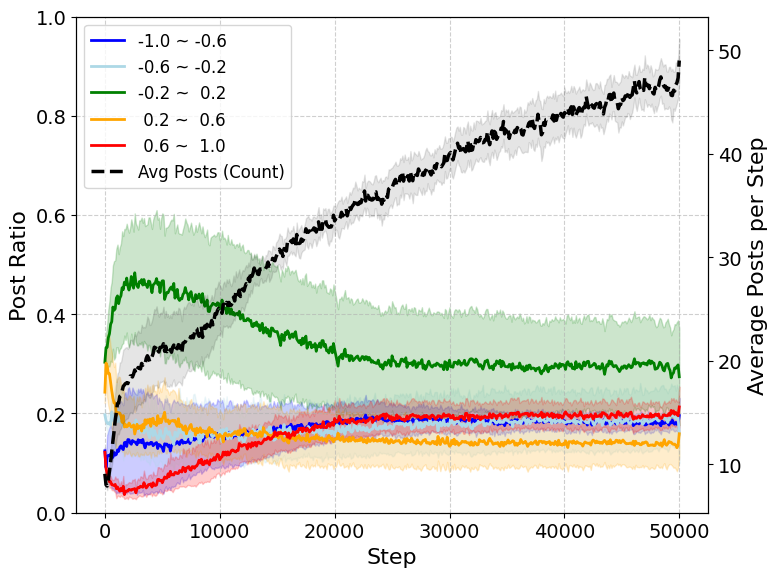

Plot generated.


In [6]:
# ==========================================
# 設定: 文字サイズなどのスタイル定義
# ==========================================
# グラフの文字サイズを全体的に大きく設定（ノートブックのスタイルに合わせる）
plt.rcParams['font.family'] = 'sans-serif'  # お好みのフォントがあれば指定
plt.rcParams['font.size'] = 14              # 基本のフォントサイズ
plt.rcParams['axes.labelsize'] = 16         # 軸ラベルのサイズ
plt.rcParams['axes.titlesize'] = 18         # タイトルのサイズ
plt.rcParams['xtick.labelsize'] = 14        # x軸目盛りのサイズ
plt.rcParams['ytick.labelsize'] = 14        # y軸目盛りのサイズ
plt.rcParams['legend.fontsize'] = 12        # 凡例のサイズ
plt.rcParams['figure.figsize'] = (8, 6)    # 画像サイズを少し大きめに

# ==========================================
# メイン処理
# ==========================================

print(f"Found {len(run_dirs)} seed directories.")

for d in run_dirs:
    seed_name = os.path.basename(d)
    # load_and_process_seed は定義済みの関数と仮定
    df = load_and_process_seed(d, seed_name)
    if df is not None:
        all_dfs.append(df)

if not all_dfs:
    print("No valid data found.")
else:
    # 2. 全データを結合
    full_df = pd.concat(all_dfs, ignore_index=True)
    
    # 3. Stepごとに集計（数値列のみを対象に平均と標準誤差 SE を計算）
    # numeric_only=True を指定して文字列列のエラーを回避
    grouped = full_df.groupby("step")
    df_mean = grouped.mean(numeric_only=True)
    df_se = grouped.sem(numeric_only=True)

    # 結果をCSV保存（オプション）
    df_mean.to_csv(os.path.join(OUTPUT_DIR, "posts_mean_all_seeds.csv"))
    print(f"Aggregated data saved to {OUTPUT_DIR}")

    # ==========================================
    # プロット作成
    # ==========================================
    fig, ax1 = plt.subplots()

    steps = df_mean.index

    # カラーマップの設定
    BIN_COLORS = ["blue", "lightblue", "green", "orange", "red"]

    # --- 左軸: 投稿割合 (bin_0 ~ bin_4) ---
    for i, bin_name in enumerate(BINS):
        if bin_name in df_mean.columns:
            mean_val = df_mean[bin_name]
            se_val = df_se[bin_name]

            current_color = BIN_COLORS[i]
            
            # ラベルを辞書から取得（なければそのままbin名）
            label_text = bin_labels.get(bin_name, bin_name)
            
            # 平均線のプロット
            ax1.plot(steps, mean_val, label=label_text, color=current_color, linewidth=2)
            
            # 誤差範囲(SE)を塗りつぶし (帯をつける処理)
            ax1.fill_between(steps, 
                             mean_val - se_val, 
                             mean_val + se_val, 
                             color=current_color, alpha=0.2) # alphaで透明度調整

    ax1.set_xlabel("Step", fontsize=16)
    ax1.set_ylabel("Post Ratio", fontsize=16)
    ax1.set_ylim(0, 1.0)
    ax1.grid(True, linestyle="--", alpha=0.6)

    # --- 右軸: 投稿数 (sumOfPosts) ---
    # 投稿数データが存在する場合のみ描画
    if "sumOfPosts" in df_mean.columns:
        ax2 = ax1.twinx()
        
        posts_mean = df_mean["sumOfPosts"]
        posts_se = df_se["sumOfPosts"]
        
        # 投稿数は黒の点線で強調
        ax2.plot(steps, posts_mean, label="Avg Posts (Count)", color="black", linestyle="--", linewidth=2.5)
        
        # 投稿数のSE帯
        ax2.fill_between(steps, 
                         posts_mean - posts_se, 
                         posts_mean + posts_se, 
                         color="black", alpha=0.1)
        
        ax2.set_ylabel("Average Posts per Step", fontsize=16)

        # 凡例の結合 (左軸と右軸をまとめる)
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        # 凡例を図の左上に表示
        ax1.legend(lines1 + lines2, labels1 + labels2, bbox_to_anchor=(0, 1), loc='upper left')
    else:
        ax1.legend()

    #plt.title(f"Post Analysis (Window={WINDOW_SIZE if 'WINDOW_SIZE' in locals() else 'N/A'}, Seeds={len(all_dfs)})")
    
    # レイアウト調整（凡例が切れないように）
    plt.tight_layout()
    
    # 画像保存
    plt.savefig(os.path.join(OUTPUT_DIR, "post_analysis_plot.png"))
    plt.show()
    
    print("Plot generated.")

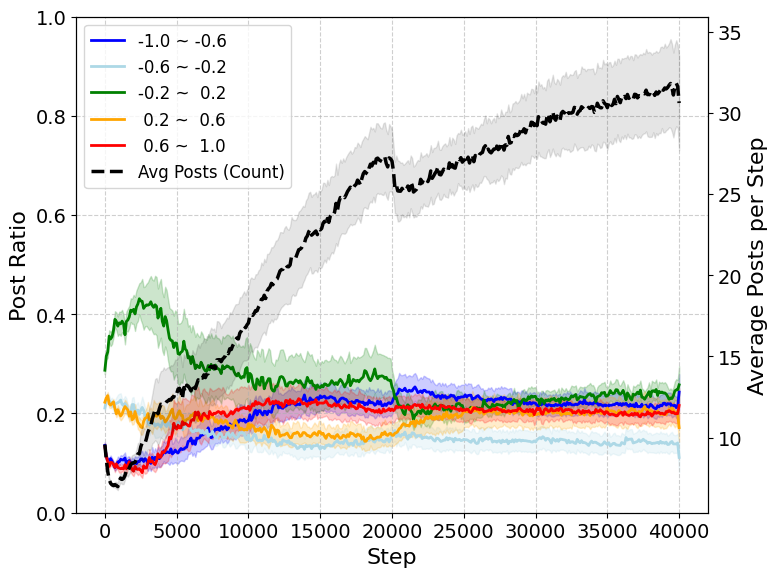

-1Version

<Figure size 800x600 with 2 Axes>

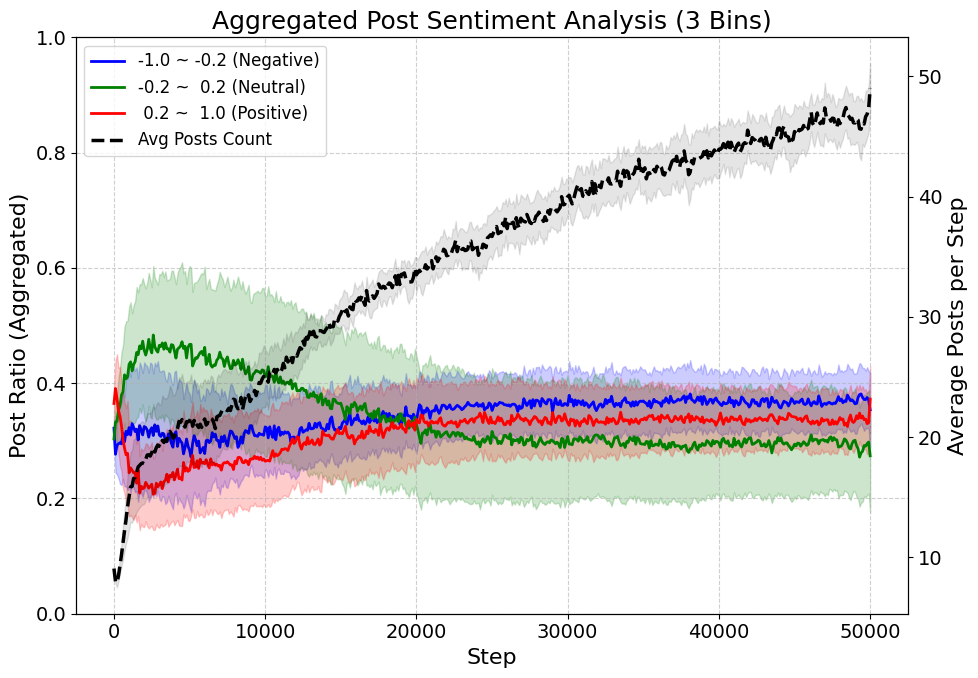

Plot generated successfully (3 bins integrated).


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# ==========================================
# 3分割統合・プロット用コード
# （Originalコードで all_dfs が作成された直後に実行することを想定）
# ==========================================

# 1. データの結合 (Originalコードですでにロードされた all_dfs を使用)
if 'all_dfs' in locals() and all_dfs:
    full_df = pd.concat(all_dfs, ignore_index=True)
    
    # --- 安全な列の統合処理 (KeyError回避) ---
    # 存在しない列を指定してもエラーにならないよう、チェックしながら足し合わせます
    
    def safe_sum(df, cols):
        """指定された列リストのうち、存在するものを足し合わせる"""
        total = 0.0
        # 少なくとも1つの列が存在するか確認するためのフラグ
        exists = False
        for c in cols:
            if c in df.columns:
                total += df[c]
                exists = True
        
        # どの列も存在しない場合は全行0のSeriesを返す（NaN回避）
        if not exists:
            return pd.Series(0.0, index=df.index)
        return total

    # 3つのカテゴリを作成
    full_df['merged_neg'] = safe_sum(full_df, ['bin_0', 'bin_1']) # -1.0 ~ -0.2
    full_df['merged_neu'] = safe_sum(full_df, ['bin_2'])          # -0.2 ~  0.2
    full_df['merged_pos'] = safe_sum(full_df, ['bin_3', 'bin_4']) #  0.2 ~  1.0

    # 2. Stepごとに集計
    grouped = full_df.groupby("step")
    df_mean = grouped.mean(numeric_only=True)
    df_se = grouped.sem(numeric_only=True)

    # ==========================================
    # プロット作成
    # ==========================================
    fig, ax1 = plt.subplots(figsize=(10, 7)) # サイズ調整

    steps = df_mean.index
    
    # プロット設定
    MERGED_BINS = ['merged_neg', 'merged_neu', 'merged_pos']
    
    bin_labels = {
        "merged_neg": "-1.0 ~ -0.2 (Negative)",
        "merged_neu": "-0.2 ~  0.2 (Neutral)",
        "merged_pos": " 0.2 ~  1.0 (Positive)"
    }
    
    BIN_COLORS = ["blue", "green", "red"]

    # --- 左軸: 投稿割合 (3分割) ---
    for i, bin_name in enumerate(MERGED_BINS):
        # 列が計算結果に含まれているか確認（safe_sumで作っているので基本はあるはずですが念のため）
        if bin_name in df_mean.columns:
            mean_val = df_mean[bin_name]
            se_val = df_se[bin_name]

            current_color = BIN_COLORS[i]
            label_text = bin_labels.get(bin_name, bin_name)
            
            # 平均線
            ax1.plot(steps, mean_val, label=label_text, color=current_color, linewidth=2)
            
            # SE帯（エラーバーの代わり）
            ax1.fill_between(steps, 
                             mean_val - se_val, 
                             mean_val + se_val, 
                             color=current_color, alpha=0.2)

    ax1.set_xlabel("Step", fontsize=16)
    ax1.set_ylabel("Post Ratio (Aggregated)", fontsize=16)
    ax1.set_ylim(0, 1.0) # 割合なので0-1固定
    ax1.grid(True, linestyle="--", alpha=0.6)
    ax1.set_title("Aggregated Post Sentiment Analysis (3 Bins)", fontsize=18)

    # --- 右軸: 投稿数 (sumOfPosts) ---
    if "sumOfPosts" in df_mean.columns:
        ax2 = ax1.twinx()
        
        posts_mean = df_mean["sumOfPosts"]
        posts_se = df_se["sumOfPosts"]
        
        ax2.plot(steps, posts_mean, label="Avg Posts Count", color="black", linestyle="--", linewidth=2.5)
        ax2.fill_between(steps, 
                         posts_mean - posts_se, 
                         posts_mean + posts_se, 
                         color="black", alpha=0.1)
        
        ax2.set_ylabel("Average Posts per Step", fontsize=16)

        # 凡例の結合
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, bbox_to_anchor=(0, 1), loc='upper left')
    else:
        ax1.legend(loc='upper left')

    plt.tight_layout()
    
    # 保存先ディレクトリ変数がなければカレントディレクトリへ
    save_dir = OUTPUT_DIR if 'OUTPUT_DIR' in locals() else '.'
    plt.savefig(os.path.join(save_dir, "post_analysis_3bins_fixed.png"))
    plt.show()
    
    print("Plot generated successfully (3 bins integrated).")

else:
    print("Error: 'all_dfs' is not defined. Please run the data loading code first.")

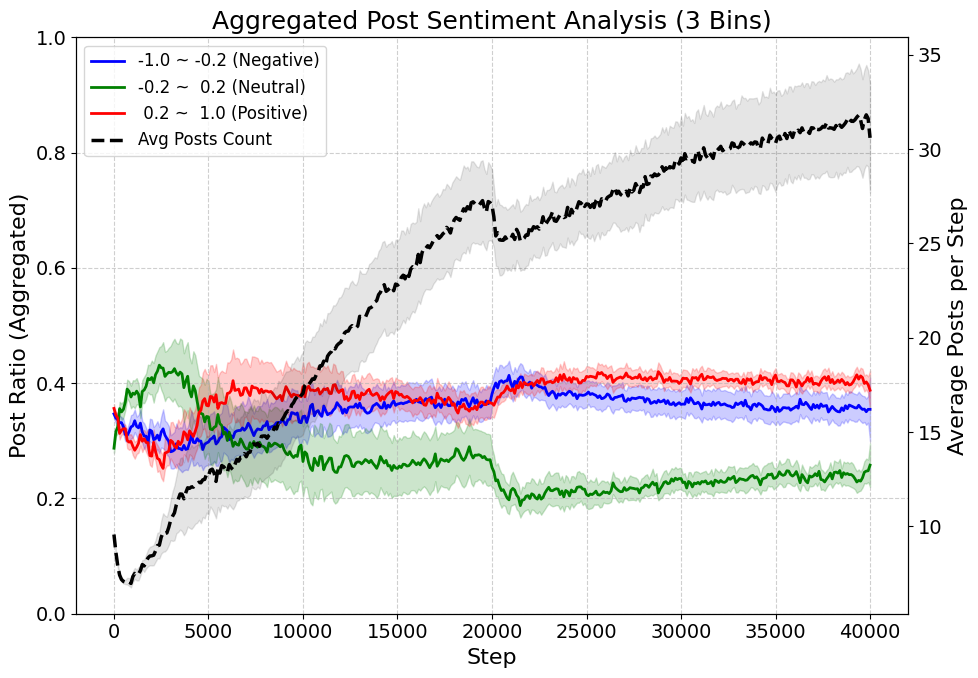

manipulation -1Version

📂 Saving variance analysis to: ./summary/BA/m_3/86236b41
⏳ Loading and aggregating variance data from raw results...
✅ Saved variance summary to ./summary/BA/m_3/86236b41/variance_evolution_summary.csv


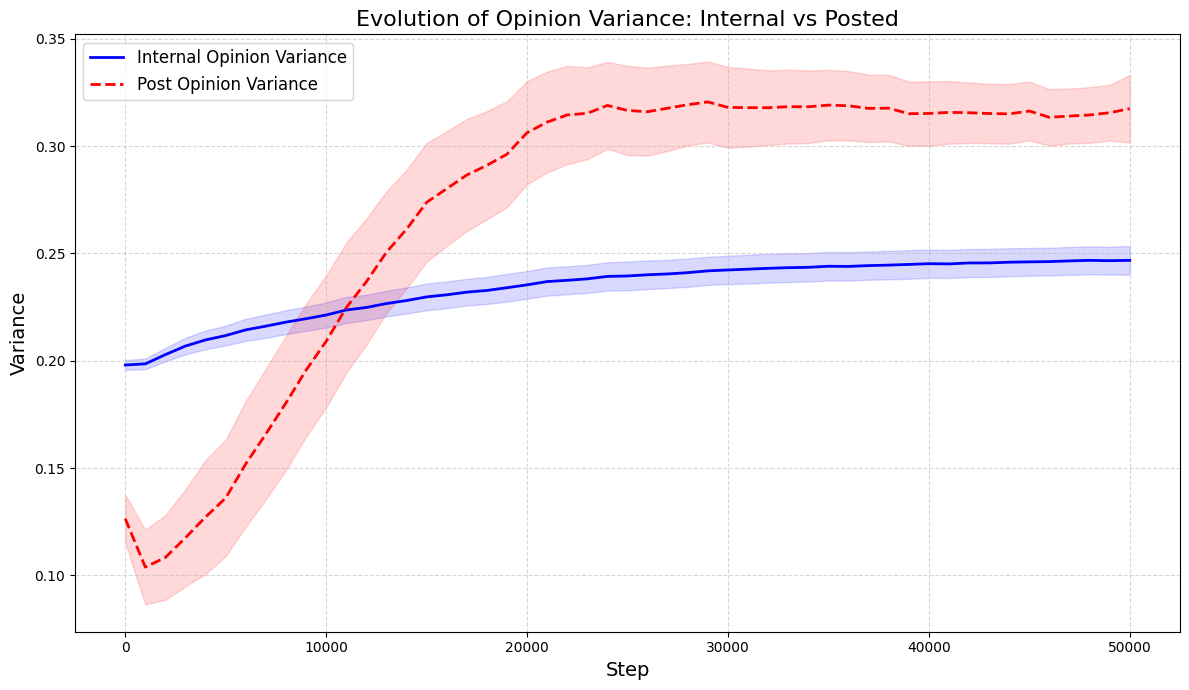


=== Summary Data (Head) ===
          opinionVar_Mean  postOpinionVar_Mean  Difference_Mean
step_bin                                                       
0                0.197986             0.126392        -0.071594
1000             0.198525             0.103828        -0.094698
2000             0.202844             0.108332        -0.094511
3000             0.206840             0.117543        -0.089297
4000             0.209680             0.127198        -0.082482


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re

# ==========================================
# 設定
# ==========================================
RESULTS_DIR = "./results"
SUMMARY_ROOT = "./summary"
METRICS_DIR_NAME = "metrics" # ★Java側でこのフォルダとCSVを出力していることが前提
STEP_BIN = 1000

def load_and_aggregate_variance(results_dir, step_bin=1000):
    run_dirs = glob.glob(os.path.join(results_dir, "run_*"))
    if not run_dirs:
        print("❌ No run directories found.")
        return None

    all_binned_data = []
    print(f"🔍 Searching for CSVs in: {os.path.join(results_dir, 'run_*', METRICS_DIR_NAME)}")

    for r_dir in run_dirs:
        metrics_path = os.path.join(r_dir, METRICS_DIR_NAME)
        # ファイル探索
        files = sorted(glob.glob(os.path.join(metrics_path, "result_*.csv")))
        
        if not files:
            # metricsフォルダが無い、またはCSVが無い場合はスキップ（ログに出す）
            # print(f"  [Skip] No csv found in {os.path.basename(r_dir)}")
            continue
            
        dfs = []
        for f in files:
            try:
                # 必要なカラムがあるか確認しつつ読む
                df = pd.read_csv(f, usecols=["step", "opinionVar", "postOpinionVar"])
                dfs.append(df)
            except ValueError:
                # usecolsのカラムが存在しない場合のエラーなどをキャッチ
                print(f"  [Warning] Missing columns in {os.path.basename(f)}")
            except Exception as e:
                pass
        
        if not dfs:
            continue

        full_df = pd.concat(dfs, ignore_index=True).sort_values("step").reset_index(drop=True)
        
        # Binning
        full_df["step_bin"] = (full_df["step"] // step_bin) * step_bin
        binned = full_df.groupby("step_bin")[["opinionVar", "postOpinionVar"]].mean()
        all_binned_data.append(binned)

    if not all_binned_data:
        print("❌ No valid variance data loaded. Check if 'metrics/result_*.csv' exists.")
        return None

    return all_binned_data

def analyze_and_visualize_variance(results_dir, summary_root, step_bin=1000):
    # 1. 保存先の特定
    search_path = os.path.join(summary_root, "**", "seeds_detail.csv")
    found_files = glob.glob(search_path, recursive=True)
    if not found_files:
        print("❌ Error: No summary data found. Please run ExperimentArchiver first.")
        return
    
    latest_file = max(found_files, key=os.path.getmtime)
    dest_dir = os.path.dirname(latest_file)
    print(f"📂 Saving variance analysis to: {dest_dir}")

    # 2. データ読み込み
    print("⏳ Loading variance data...")
    binned_list = load_and_aggregate_variance(results_dir, step_bin)
    
    if not binned_list:
        return

    # 3. 集計
    combined = pd.concat(binned_list)
    grouped = combined.groupby(level=0)
    
    df_stats = grouped.mean()
    df_stats.columns = [f"{c}_Mean" for c in df_stats.columns]
    
    df_se = grouped.sem()
    df_se.columns = [f"{c}_SE" for c in df_se.columns]
    
    final_df = pd.concat([df_stats, df_se], axis=1).sort_index()
    
    # 差分（Gap）の計算
    final_df["Gap_Mean"] = final_df["postOpinionVar_Mean"] - final_df["opinionVar_Mean"]
    # 簡易的なGapのSE（厳密には共分散が必要だが、概算として和の平方根などを使うか、ここでは簡略化のためSEは合算しない）
    
    # 保存
    output_csv = os.path.join(dest_dir, "variance_evolution_summary.csv")
    final_df.to_csv(output_csv, index=True, index_label="Step")
    print(f"✅ Saved variance summary to {output_csv}")

    # 4. 可視化 (2段構成に変更: 上段=分散推移, 下段=差分推移)
    steps = final_df.index
    
    fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    
    # --- 上段: 分散の推移 ---
    ax = axes[0]
    ax.plot(steps, final_df["opinionVar_Mean"], label="Internal Opinion Variance", color="blue", linewidth=2)
    ax.fill_between(steps, 
                    final_df["opinionVar_Mean"] - final_df["opinionVar_SE"], 
                    final_df["opinionVar_Mean"] + final_df["opinionVar_SE"], 
                    color="blue", alpha=0.15)

    ax.plot(steps, final_df["postOpinionVar_Mean"], label="Post Opinion Variance", color="red", linewidth=2, linestyle="--")
    ax.fill_between(steps, 
                    final_df["postOpinionVar_Mean"] - final_df["postOpinionVar_SE"], 
                    final_df["postOpinionVar_Mean"] + final_df["postOpinionVar_SE"], 
                    color="red", alpha=0.15)

    ax.set_title("Evolution of Opinion Variance", fontsize=14)
    ax.set_ylabel("Variance", fontsize=12)
    ax.legend(fontsize=12, loc='upper left')
    ax.grid(True, linestyle="--", alpha=0.5)

    # --- 下段: ギャップの推移 (Post - Internal) ---
    ax = axes[1]
    ax.plot(steps, final_df["Gap_Mean"], label="Gap (Post - Internal)", color="purple", linewidth=2)
    ax.fill_between(steps, 0, final_df["Gap_Mean"], color="purple", alpha=0.1) # 0との差を塗りつぶし
    
    ax.axhline(0, color='black', linewidth=1)
    ax.set_title("Gap: How much more polarized are posts than internal opinions?", fontsize=14)
    ax.set_xlabel("Step", fontsize=12)
    ax.set_ylabel("Variance Difference", fontsize=12)
    ax.legend(fontsize=12, loc='upper left')
    ax.grid(True, linestyle="--", alpha=0.5)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    analyze_and_visualize_variance(RESULTS_DIR, SUMMARY_ROOT, STEP_BIN)